# Machine Learning LAB 1 
Course 2023/24: P. Zanuttigh, M. Caligiuri, F. Lincetto

The notebook contains some simple tasks to be performed about **classification and regression**. <br>
Complete all the **required code sections** and **answer to all the questions**. <br>

### IMPORTANT for the evaluation score:
1. **Read carefully all cells** and **follow the instructions**.
1. **Rerun all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
2. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
3. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command** - otherwise points will be deduced.
4. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

##  Classification of Stayed/Churned Customers

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB1.ipynb** otherwise your homework could get lost
<br>

**Student name**: Giada Aggio<br>
**ID Number**: 2089092

### Dataset description

The Customer Churn table contains information on all 3,758 customers from a Telecommunications company in California in Q2 2022. 
The dataset contains three features:
- **Tenure in Months**: Number of months the customer has stayed with the company
- **Monthly Charge**: The amount charged to the customer monthly
- **Age**: Customer's age

The aim of the task is to predict if a customer will churn or not based on the three features.

<center>

![COVER](data/dataset-cover.png "COVER")

</center>

# We first **import** all **the packages** that are needed.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model, preprocessing
import time

Change some global settings for layout purposes.

In [2]:
# if you are in the jupyter notebook environment you can change the 'inline' option with 'notebook' to get interactive plots
%matplotlib inline
# change the limit on the line length and crop to 0 very small numbers, for clearer printing
np.set_printoptions(linewidth=500, suppress=True)

## A) Perceptron
In the following cells we will **implement** the **perceptron** algorithm and use it to learn a halfspace.

**TO DO (A.0):** **Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [3]:
IDnumber = 2089092 -1 # YOUR_ID
np.random.seed(IDnumber)

Before proceding to the training steps, we **load the dataset and split it** in training and test set (the **training** set is **typically larger**, here we use a 75% training 25% test split).
The **split** is **performed after applying a random permutation** to the dataset, such permutation will **depend on the seed** you set above. Try different seeds to evaluate the impact of randomization.<br><br>
**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

### The Dataset
The dataset is a `.csv` file containing three input features and a label. Here is an example of the first 4 rows of the dataset: 

<center>

Tenure in Months | Monthly Charge | Age | Customer Status |
| -----------------| ---------------|-----|-----------------|
| 9 | 65.6 | 37 | 0 |
| 9 | -4.0 | 46 | 0 |
| 4 | 73.9 | 50 | 1 |
| ... | ... | ... | ... |

</center>

Customer Status is 0 if the customer has stayed with the company and 1 if the customer has churned.

In [4]:
def load_dataset(filename):
    data_train = pd.read_csv(filename)
    #permute the data
    data_train = data_train.sample(frac=1).reset_index(drop=True) # shuffle the data
    X = data_train.iloc[:, 0:3].values # Get first two columns as the input
    Y = data_train.iloc[:, 3].values # Get the third column as the label
    Y = 2*Y-1 # Make sure labels are -1 or 1 (0 --> -1, 1 --> 1)
    return X,Y

In [5]:
# Load the dataset
X, Y = load_dataset('data/telecom_customer_churn_cleaned.csv')

<div class="alert alert-block alert-success">
Let's represent our data on a 3d plot.
 </div>

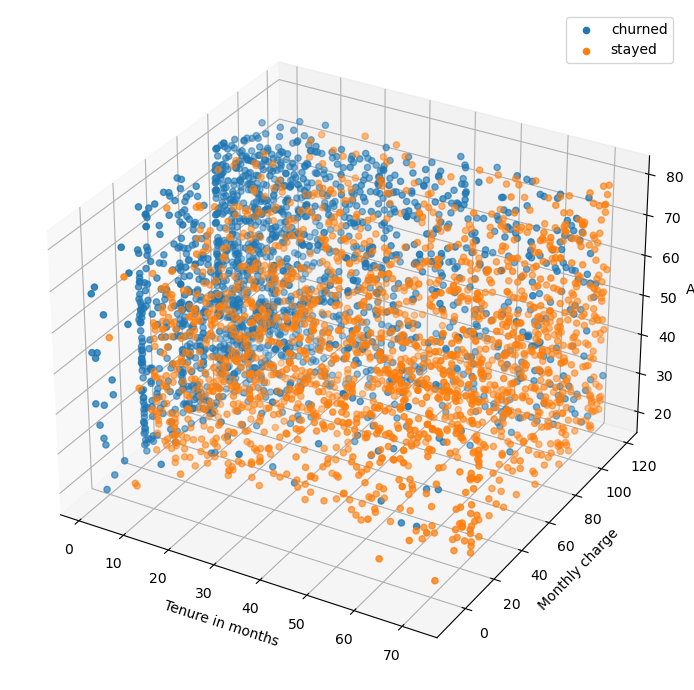

In [6]:
# 3d plot to see our dataset
from mpl_toolkits.mplot3d import Axes3D

X_plus1 = X[np.where(Y==1)]
X_min1 = X[np.where(Y==-1)]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(X_plus1[:,0],X_plus1[:,1],X_plus1[:,2],label='churned')
scatter = ax.scatter(X_min1[:,0],X_min1[:,1],X_min1[:,2],label='stayed')
ax.set_xlabel('Tenure in months')
ax.set_ylabel('Monthly charge')
ax.set_zlabel('Age')
plt.legend()

plt.tight_layout()
plt.show()

We are going to differentiate (classify) between **class "1" (churned)** and **class "-1" (stayed)**

# Split data in training and test sets



Given $m$ total data, denote with $m_{t}$ the part used for training. Keep $m_t$ data as training data, and $m_{test}:= m-m_{t}$. <br>
For instance one can take $m_t=0.75m$ of the data as training and $m_{test}=0.25m$ as testing. <br>
Let us define as define

$\bullet$ $S_{t}$ the training data set

$\bullet$ $S_{test}$ the testing data set


The reason for this splitting is as follows:

TRAINING DATA: The training data are used to compute the empirical loss
$$
L_S(h) = \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
which is used to estimate $h$ in a given model class ${\cal H}$.
i.e. 
$$
\hat{h} = {\rm arg\; min}_{h \in {\cal H}} \, L_S(h)
$$

TESTING DATA: The test data set can be used to estimate the performance of the final estimated model
$\hat h_{\hat d_j}$ using:
$$
L_{{\cal D}}(\hat h_{\hat d_j}) \simeq \frac{1}{m_{test}} \sum_{ z_i \in S_{test}} \ell(\hat h_{\hat d_j},z_i)
$$

**TO DO (A.1):** **Divide** the **data into training and test set** (**75%** of the data in the **first** set, **25%** in the **second** one). <br>
<br>
Notice that as is common practice in Statistics and Machine Learning, **we scale the data** (= each variable) so that it is centered **(zero mean)** and has **standard deviation equal to 1**. <br>
This helps in terms of numerical conditioning of the (inverse) problems of estimating the model (the coefficients of the linear regression in this case), as well as to give the same scale to all the coefficients.

In [7]:
# compute the splits
total = len(X)
m_training = int(0.75*total)                      # to compute how many elements in the training set
print('m_training =',m_training)

# m_test is the number of samples in the test set (total-training)
m_test =  total - m_training                     # to compute how many elements in the test set
print('m_test =',m_test)

# X_training = instances for training set
X_training =  X[0:m_training]
# Y_training = labels for the training set
Y_training =  Y[0:m_training]

# X_test = instances for test set
X_test =  X[m_training:total]
# Y_test = labels for the test set
Y_test =  Y[m_training:total]

print("\nNumber of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("\nNumber of night instances in test:", np.sum(Y_test==-1))
print("Number of day instances in test:", np.sum(Y_test==1))

# standardize the input matrix
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training =  scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_test =  scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

m_training = 2817
m_test = 940

Number of samples in the train set: 2817
Number of samples in the test set: 940

Number of night instances in test: 482
Number of day instances in test: 458
Mean of the training input data: [0. 0. 0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [0.05085368 0.01079658 0.02832442]
Std of the test input data: [1.03093336 0.99704219 0.98403495]


We **add a 1 in front of each sample** so that we can use a vector in **homogeneous coordinates** to describe all the coefficients of the model. This can be done with the function $hstack$ in $numpy$.

In [8]:
def to_homogeneous(X_training, X_test):
    # Add a 1 to each sample (homogeneous coordinates)
    X_training = np.hstack( [np.ones( (X_training.shape[0], 1) ), X_training] )
    X_test = np.hstack( [np.ones( (X_test.shape[0], 1) ), X_test] )
    
    return X_training, X_test

In [9]:
# convert to homogeneous coordinates using the function above
X_training, X_test = to_homogeneous(X_training, X_test)
print("Training set in homogeneous coordinates:")
print(X_training[:10])

Training set in homogeneous coordinates:
[[ 1.          1.80248128  0.84291322 -0.72512069]
 [ 1.          1.7603953  -1.58245777 -0.78356103]
 [ 1.         -0.89102168  0.9029224   1.08652966]
 [ 1.          1.12910554 -0.75066387  0.61900699]
 [ 1.         -0.09138799  0.26115757  1.90469433]
 [ 1.         -1.18562357 -1.58745853 -1.54328537]
 [ 1.          1.71830932  0.22448529 -0.08227702]
 [ 1.         -1.18562357  0.11613538  0.20992465]
 [ 1.          0.16112791  0.17947841  0.38524565]
 [ 1.         -1.18562357 -1.57245624  0.85276832]]


**TO DO (A.2):** Now **complete** the function *perceptron*. <br>
The **perceptron** algorithm **does not terminate** if the **data** is not **linearly separable**, therefore your implementation should **terminate** if it **reached the termination** condition seen in class **or** if a **maximum number of iterations** have already been run, where one **iteration** corresponds to **one update of the perceptron weights**. In case the **termination** is reached **because** the **maximum** number of **iterations** have been completed, the implementation should **return the best model** seen throughout .

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model (or the latest, if the termination condition is reached)
- $best\_error$: the *fraction* of misclassified samples for the best model

In [10]:
def count_errors(current_w, X, Y):
    out = np.sign(np.dot(X, current_w))
    misclassified_indices = np.where(out != Y)[0]

    if len(misclassified_indices) == 0:
        return -1, None  # no misclassified samples
    else:
        return len(misclassified_indices), misclassified_indices[0]

def perceptron_update(current_w, x, y):
    new_w = current_w + y * x
    return new_w

def perceptron_no_randomization(X, Y, max_num_iterations):
    # Initialize some support variables
    num_samples = X.shape[0]
    # best_errors will keep track of the best (minimum) number of errors
    # seen throughout training, used for the update of the best_w variable
    best_error = num_samples + 1
    
    # Initialize weights of the algorithm with w=0
    curr_w = np.zeros(X.shape[1])
    # The best variable will be used to keep track of the best solution
    best_w = curr_w.copy()

    # compute the number of misclassified samples and index of the first of them
    num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
    
    # update the 'best' variables
    if num_misclassified < best_error:
        best_error = num_misclassified
        best_w = curr_w.copy()
        
    # initialize number of iterations
    num_iter = 0

    # Main loop continue until all samples correctly classified or max # iterations reached
    # Remember that to signify that no errors were found we set index_misclassified = -1
    
    while index_misclassified != -1 and num_iter < max_num_iterations:
        x_miscl = X[index_misclassified]
        y_miscl = Y[index_misclassified]

        # update the weights vector
        curr_w = perceptron_update(curr_w, x_miscl, y_miscl)

        # check for misclassified samples again 
        num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
        
        # update the 'best' variables
        if num_misclassified < best_error:
            best_error = num_misclassified
            best_w = curr_w.copy()

        # update number of iterations
        num_iter += 1

    # return best error as ratio wrt the total number of samples
    best_error = best_error / num_samples 

    return best_w, best_error


Now we use the implementation above of the perceptron to learn a model from the training data using 30 iterations and print the error of the best model we have found.

In [11]:
start = time.time()
# Now run the perceptron for 30 iterations
w_found, error = perceptron_no_randomization(X_training,Y_training, 30)
print("Training Error of perceptron (30 iterations): " + str(error))
end = time.time()
print('Computing time non-randomized perceptron =',end-start)

Training Error of perceptron (30 iterations): 0.28434504792332266
Computing time non-randomized perceptron = 0.006189107894897461


**TO DO (A.3):** use the best model $w\_found$ to **predict the labels for the test dataset** and print the fraction of misclassified samples in the test set (the test error that is an estimate of the true loss).

In [12]:
errors, _ = count_errors(w_found, X_test,Y_test)

true_loss_estimate = errors/len(Y_test)     # Error rate on the test set
# NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perceptron (30 iterations): " + str(true_loss_estimate))

Test Error of perceptron (30 iterations): 0.27872340425531916


**TO DO (A.4):** implement the correct randomized version of the perceptron such that at each iteration the algorithm picks a random misclassified sample and updates the weights using that sample.

In [13]:
# correct randomized version of perceptron
def count_errors_rand(current_w, X, Y):
    out = np.sign(np.dot(X, current_w))
    misclassified_indices = np.where(out != Y)[0]

    # randomize misclassified indeces 
    np.random.shuffle(misclassified_indices)

    if len(misclassified_indices) == 0:
        return -1, None  # no misclassified samples
    else:
        return len(misclassified_indices), misclassified_indices[0]

def perceptron(X, Y, max_num_iterations):
    # initialize some support variables
    num_samples = X.shape[0]
    best_error = num_samples + 1
    
    # initialize weights of the algorithm with w=random
    curr_w = np.random.rand(X.shape[1])
    best_w = curr_w.copy()

    # compute the number of misclassified samples 
    num_misclassified, index_misclassified = count_errors_rand(curr_w, X, Y)
    
    # update the 'best' variables
    if num_misclassified < best_error:
        best_error = num_misclassified
        best_w = curr_w.copy()
        
    # initialize number of iterations
    num_iter = 0
    
    while index_misclassified != -1 and num_iter < max_num_iterations:
        x_miscl = X[index_misclassified]
        y_miscl = Y[index_misclassified]

        curr_w = perceptron_update(curr_w, x_miscl, y_miscl)

        num_misclassified, index_misclassified = count_errors_rand(curr_w, X, Y)
        
        # update the 'best' variables
        if num_misclassified < best_error:
            best_error = num_misclassified
            best_w = curr_w.copy()

        num_iter += 1

    # return best error as ratio wrt the total number of samples
    best_error = best_error / num_samples 

    return best_w, best_error

**TO DO (A.5):** Now test the correct version of the perceptron using 30 iterations and print the error of the best model we have found.

In [14]:
start = time.time()
# Now run the perceptron for 30 iterations
w_found, error = perceptron(X_training,Y_training, 30)
print("Training Error of perceptron (30 iterations): " + str(error))
end = time.time()
print('Computing time randomized perceptron =',end-start)

errors, _ = count_errors(w_found, X_test,Y_test)

true_loss_estimate = errors/len(Y_test)     # Error rate on the test set
# NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perceptron (30 iterations): " + str(true_loss_estimate))

Training Error of perceptron (30 iterations): 0.25310614128505504
Computing time randomized perceptron = 0.006426811218261719
Test Error of perceptron (30 iterations): 0.24574468085106382


**TO DO (A.Q1) [Answer the following]** <br>
What is the difference between the two versions of the perceptron? Can you explain why there is this difference? <br>

<div class="alert alert-block alert-info">
**ANSWER A.Q1**:<br>
The main difference is that in the correct version of the Perceptron algorithm we use the randomization of the misclassified indeces for every iteration while in the non randomized one we always consider the first misclassified sample.
    
Looking at the results we get,we see that the randomized perceptron always outputs smaller errors than the ones that we get from the non randomized one. This difference is due to the randomization of the indeces of the misclassified samples. 
 </div>

### Now consider only a the random version of the perceptron

**TO DO (A.Q2) [Answer the following]** <br>
What about the difference between the training error and the test error  in terms of fraction of misclassified samples? Explain what you observe. (Notice that with a very small dataset like this one results can change due to randomization, try to run with different random seeds if you get unexpected results).

<div class="alert alert-block alert-info">
**ANSWER A.Q2**:<br>
The random version of the perceptron outputs both a training error and a test error around 0.25, meaning that our model is doing fine but it's not finding the perfect solution for our problem, namely it can't separate the two labels. This may be due to the fact that our dataset is not linearly separable but to be sure about this we have to try running the algorithm for more iterations.

##### I changed the seed (-1) to get better results
 </div>

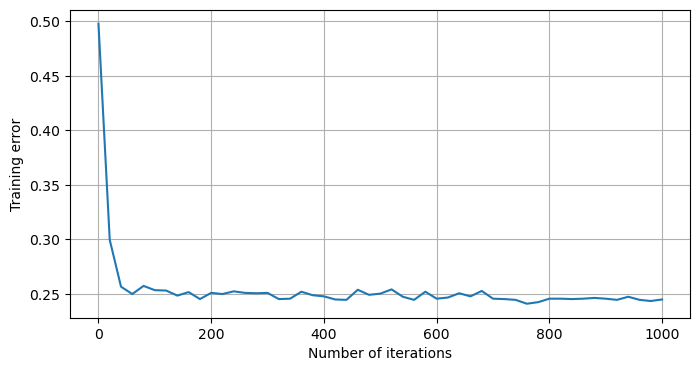

In [15]:
# Plot the loss with respect to the number of iterations
plt.figure(figsize=(8,4))

num_iters = np.arange(0, 1001, 20)
errors = []

for num_iter in num_iters:
    _, error = perceptron(X_training, Y_training, num_iter)
    errors.append(error)

plt.plot(num_iters, errors)
plt.xlabel('Number of iterations')
plt.ylabel('Training error')
plt.grid()
plt.show()

# NOTE how the training loss decreases as we increase the number of iterations

**TO DO (A.6):** Copy the code from the last 2 cells above in the cell below and repeat the training with 3000 iterations. Then print the error in the training set and the estimate of the true loss obtained from the test set.

In [16]:
start = time.time()
w_found, error = perceptron(X_training,Y_training,3000)
print("Training Error of perceptron (3000 iterations): " + str(error))

num_errors, _ =  count_errors(w_found,X_test,Y_test)  

true_loss_estimate = num_errors/len(Y_test)
print("Test Error of perceptron (3000 iterations): " + str(true_loss_estimate))
end = time.time()
print('Computation time perceptron (3000 iterations) =',end-start)

Training Error of perceptron (3000 iterations): 0.24423145189918352
Test Error of perceptron (3000 iterations): 0.23404255319148937
Computation time perceptron (3000 iterations) = 0.5257720947265625


**TO DO (A.Q3) [Answer the following]** <br>
What about the difference between the training error and the test error (in terms of the fraction of misclassified samples) when running for a larger number of iterations? Explain what you observe and compare with the previous case.

<div class="alert alert-block alert-info">
**ANSWER A.Q3**:<br>
The errors when running for 3000 iterations are smaller than the ones we get when the algorithm runs for 30 iterations, in particular the training error is around 0.24 and the test error is lower, around 0.23. Our model is doing fine but even on a large number of iterations it doesn't separate all the data. Our dataset is not separable. 
</div>

<div class="alert alert-block alert-success">
I tried to implement even the Perceptron using sklearn to double check the results.
</div>

In [17]:
from sklearn.linear_model import Perceptron
p = Perceptron(shuffle=True, random_state = 42, max_iter = 3000)
learn_p_train = p.fit(X_training,Y_training)

predict_p_train = p.predict(X_training)
error_train = (predict_p_train != Y_training).sum()
errorrate_train = error_train/len(X_training)
print("Error rate on training set: "+str(errorrate_train))

predict_p_test = p.predict(X_test)
error_test = (predict_p_test != Y_test).sum()
errorrate_test = error_test/len(X_test)
print('Error rate on test set: '+str(errorrate_test))

Error rate on training set: 0.4728434504792332
Error rate on test set: 0.4968085106382979


This confirms that our dataset **isn't linearly separable**. 

# B) Logistic Regression
Now we use **logistic regression**, exploiting the implementation in **Scikit-learn**, to predict labels. We will also plot the decision boundaries of logistic regression.

We first load the dataset again.

In [18]:
# load the dataset
X, Y = load_dataset('data/telecom_customer_churn_cleaned.csv')

In [19]:
# separate the dataset into training and test
total = len(X)
m_training = int(0.75*total)                      # to compute how many elements in the training set
print('m_training =',m_training)

# m_test is the number of samples in the test set (total-training)
m_test =  total - m_training                     # to compute how many elements in the test set
print('m_test =',m_test)

# X_training = instances for training set
X_training =  X[0:m_training]
# Y_training = labels for the training set
Y_training =  Y[0:m_training]

# X_test = instances for test set
X_test =  X[m_training:total]
# Y_test = labels for the test set
Y_test =  Y[m_training:total]

print("\nNumber of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("\nNumber of night instances in test:", np.sum(Y_test==-1))
print("Number of day instances in test:", np.sum(Y_test==1))

m_training = 2817
m_test = 940

Number of samples in the train set: 2817
Number of samples in the test set: 940

Number of night instances in test: 454
Number of day instances in test: 486


To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5)$

($C$ is a parameter related to *regularization*, a technique that
we will see later in the course. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in class.)

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. <br>
See the Scikit-learn documentation for how to use it [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

**TO DO (B.1):** **Define** the **logistic regression** model, then **learn** the model using **the training set** and **predict** on the **test set**. Then **print** the **fraction of samples misclassified** in the training set and in the test set.

In [20]:
# part on logistic regression for 2 classes
logreg = linear_model.LogisticRegression(C=1e5)
# C should be very large to ignore regularization (see above)

# learn from training set: hint use fit(...)
learn_training = logreg.fit(X_training,Y_training)
print("Intercept:" , logreg.intercept_)
print("Coefficients:" , logreg.coef_)

# predict on training set
predicted_training = logreg.predict(X_training)

# print the error rate = fraction of misclassified samples
error_count_training = (predicted_training != Y_training).sum()
error_rate_training = error_count_training/len(X_training)
print("Error rate on training set: "+str(error_rate_training))

# predict on test set
predicted_test = logreg.predict(X_test)

#print the error rate = fraction of misclassified samples
error_count_test = (predicted_test != Y_test).sum()
error_rate_test = error_count_test/len(Y_test)
print("Error rate on test set: " + str(error_rate_test))

Intercept: [-0.98152587]
Coefficients: [[-0.05998042  0.02855059  0.01477922]]
Error rate on training set: 0.24742634007809727
Error rate on test set: 0.2425531914893617


**TO DO (B.2)** Now **pick two features** and restrict the dataset to include only two features, whose indices are specified in the $idx0$ and $idx1$ variables below. Then split into training and test.

In [21]:
feature_names  = ["Tenure in Months","Monthly Charge","Age"]

# Select the two features to use
idx0 = feature_names.index('Tenure in Months')
idx1 = feature_names.index('Monthly Charge')

X_reduced = X[:,[idx0, idx1]]

# re-initialize the dataset splits, with the reduced sets
X_training = X_reduced[0:m_training]
Y_training = Y[0:m_training]

X_test = X_reduced[m_training:total]
Y_test = Y[m_training:total]

Now learn a model using the training data and measure the performances.

In [22]:
# learning from training data
learn_training = logreg.fit(X_training,Y_training)
print("Intercept:" , logreg.intercept_)
print("Coefficients:" , logreg.coef_)

# predict on training set
predicted_training = logreg.predict(X_training)

# print the error rate = fraction of misclassified samples
error_count_training = (predicted_training != Y_training).sum()
error_rate_training = error_count_training/len(X_training)
print("Error rate on training set: "+str(error_rate_training))

# predict on test set
predicted_test = logreg.predict(X_test)

#print the error rate = fraction of misclassified samples
error_count_test = (predicted_test != Y_test).sum()

# print the error rate = fraction of misclassified samples
error_rate_test = error_count_test/len(Y_test)
print("Error rate on test set: " + str(error_rate_test))

Intercept: [-0.35160212]
Coefficients: [[-0.05984486  0.02948685]]
Error rate on training set: 0.24565140220092296
Error rate on test set: 0.23829787234042554


**TO DO (B.Q1) [Answer the following]** <br>
Which features did you select and why? <br>
Compare the perfomance of the classifiers trained with every combination of two features with that of the baseline (which used all 3 features).

<div class="alert alert-block alert-info">
**ANSWER B.Q1**:<br>
Let's compare the performance of the classifiers trained with all the combinations of two features:
    
* Using all 3 features we find a training error of about 0.29 and a test error of about 0.27.    
* Using Tenure in Months and Monthly Charge the training error is 0.25 and the test error is 0.24.  
* Using Tenure in Months and Age the training error is 0.29 and the test error is 0.27.   
* Using Monthly Charge and Age the training error is 0.41 and the test error is 0.42.

Looking at these values I choose to use the first two features in the list, namely the Tenure in Months and the Monthly Charge, first of all because they're the most objective ones since the age is quite unrelate to the decision of the client to stay with the company or ot churn. Moreover I decided not to use the combination Age and Monthly Charge since it is the only one to result in an overfitting of the data.
</div>